In [1]:
#dataset source: https://www.kaggle.com/datasets/sandibaressiegota/robot-kinematics-dataset/data
#favourite track on this project: https://youtu.be/ytA2MrPEZdA?si=NTmYVv9EjmXrEbyX

In [2]:
import numpy as np
import pandas as pd 
import torch
from sklearn.model_selection import train_test_split


In [3]:
data = pd.read_csv('data/robot_inverse_kinematics_dataset.csv') # загружаем датасет

X_df = data.iloc[:, :6]
y_df = data.iloc[:, 6:]
X_df

,q1,q2,q3,q4,q5,q6
0,-1.510,-0.763,1.85,-0.817,0.9120,2.320
1,-2.840,0.520,1.58,-1.270,-1.3900,0.617
2,-1.230,0.695,1.22,-1.130,0.0343,6.270
3,-1.990,1.060,1.74,-1.760,-1.2400,4.760
4,1.050,0.836,1.34,-1.890,0.4840,4.380
...,...,...,...,...,...,...
14995,0.314,-0.534,1.76,1.970,-0.6990,3.870
14996,2.450,1.360,1.55,2.780,-0.3210,5.310
14997,2.620,1.410,1.56,2.540,1.0600,5.870
14998,-1.890,1.850,1.51,1.090,0.6970,4.070


In [4]:
#test & train split
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df,
    test_size=0.2,       
    train_size=0.8,      
    random_state=42,     
    shuffle=False         
)
X_train


,q1,q2,q3,q4,q5,q6
0,-1.510,-0.763,1.85,-0.817,0.9120,2.320
1,-2.840,0.520,1.58,-1.270,-1.3900,0.617
2,-1.230,0.695,1.22,-1.130,0.0343,6.270
3,-1.990,1.060,1.74,-1.760,-1.2400,4.760
4,1.050,0.836,1.34,-1.890,0.4840,4.380
...,...,...,...,...,...,...
11995,2.160,1.330,1.45,0.442,-1.5700,5.660
11996,1.950,-0.459,1.63,0.264,1.8200,1.210
11997,-0.915,0.919,1.40,-1.050,1.2000,2.080
11998,2.870,-1.590,1.85,-0.386,2.0200,5.990


In [5]:


def create_sequences(X: pd.DataFrame, y: pd.DataFrame, T: int):
    # скользящее окно длины T
    X_vals = X.values              
    y_vals = y.values               

    n_samples = len(X_vals) - T + 1
    X_seq = np.zeros((n_samples, T, X_vals.shape[1]), dtype=float)
    y_seq = np.zeros((n_samples, y_vals.shape[1]), dtype=float)

    for i in range(n_samples):
        X_seq[i] = X_vals[i : i + T]   
        y_seq[i] = y_vals[i + T - 1]   

    return X_seq, y_seq


In [7]:
from torch.utils.data import TensorDataset, DataLoader

X_seq,y_seq = create_sequences(X_train,y_train,10)

X_tensor = torch.from_numpy(X_seq).float()    
y_tensor = torch.from_numpy(y_seq).float()     

dataset = TensorDataset(X_tensor, y_tensor)
loader  = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
for test_xx, test_yy in loader: # get sample item from dataset 
    print(test_xx[0])    
    print(test_yy[0])
    break

tensor([[-2.1300,  0.2410,  1.4300,  2.3000,  1.1700,  4.2200],
        [ 2.2900, -1.1400,  1.4200,  0.1650, -1.7800,  2.5000],
        [ 1.4900,  0.0211,  1.9000,  1.5500, -0.8220,  5.5300],
        [ 2.0900,  1.6200,  1.6300,  1.7700,  1.6100,  5.3600],
        [ 1.1900,  0.6180,  1.2800, -1.8100, -1.6300,  1.9700],
        [ 2.2600,  1.6900,  1.6300, -1.6900,  1.8000,  3.2900],
        [ 0.2660,  1.1800,  1.5000,  0.8170,  1.9200,  2.7600],
        [-0.1000,  1.5000,  1.4600,  0.6640,  1.6800,  1.0900],
        [ 2.3500, -0.0661,  1.8600, -0.4560,  1.9000,  3.3300],
        [ 2.1700,  1.2400,  1.6100, -0.3570,  0.3530,  3.8100]])
tensor([ 0.0483, -0.0395,  0.4500])


In [16]:
import torch.nn as nn

class ForwardKinematicsLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size   = input_dim,
            hidden_size  = hidden_dim,
            num_layers   = num_layers,
            batch_first  = True,
            dropout      = dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim, 3)  # три выхода: x, y, z

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        _, (h_n, _) = self.lstm(x)      
        # h_n: (num_layers, batch, hidden_dim)
        h_last = h_n[-1]                
        out = self.fc(h_last)        # (batch, 3)
        return out


In [17]:
model = ForwardKinematicsLSTM(hidden_dim=128, num_layers=2, dropout=0.3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred  = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    epoch_loss /= len(loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {epoch_loss:.4f}")

Epoch 1/50 — Loss: 0.0100
Epoch 2/50 — Loss: 0.0088
Epoch 3/50 — Loss: 0.0073
Epoch 4/50 — Loss: 0.0054
Epoch 5/50 — Loss: 0.0039
Epoch 6/50 — Loss: 0.0030
Epoch 7/50 — Loss: 0.0025
Epoch 8/50 — Loss: 0.0022
Epoch 9/50 — Loss: 0.0019
Epoch 10/50 — Loss: 0.0017
Epoch 11/50 — Loss: 0.0016
Epoch 12/50 — Loss: 0.0014
Epoch 13/50 — Loss: 0.0013
Epoch 14/50 — Loss: 0.0012
Epoch 15/50 — Loss: 0.0012
Epoch 16/50 — Loss: 0.0011
Epoch 17/50 — Loss: 0.0011
Epoch 18/50 — Loss: 0.0011
Epoch 19/50 — Loss: 0.0010
Epoch 20/50 — Loss: 0.0010
Epoch 21/50 — Loss: 0.0010
Epoch 22/50 — Loss: 0.0010
Epoch 23/50 — Loss: 0.0010
Epoch 24/50 — Loss: 0.0009
Epoch 25/50 — Loss: 0.0009
Epoch 26/50 — Loss: 0.0009
Epoch 27/50 — Loss: 0.0009
Epoch 28/50 — Loss: 0.0009
Epoch 29/50 — Loss: 0.0009
Epoch 30/50 — Loss: 0.0008
Epoch 31/50 — Loss: 0.0008
Epoch 32/50 — Loss: 0.0008
Epoch 33/50 — Loss: 0.0008
Epoch 34/50 — Loss: 0.0008
Epoch 35/50 — Loss: 0.0008
Epoch 36/50 — Loss: 0.0008
Epoch 37/50 — Loss: 0.0008
Epoch 38/5

In [20]:
X_seq_test,y_seq_test = create_sequences(X_test,y_test,10)

X_tensor_test = torch.from_numpy(X_seq_test).float()    
y_tensor_test = torch.from_numpy(y_seq_test).float()     

test_dataset = TensorDataset(X_tensor_test, y_tensor_test)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [24]:
model.eval()
y_true = y_test.values
y_test_pred = []
with torch.no_grad():
    for Xb, _ in test_loader:
        y_test_pred.append(model(Xb).cpu().numpy())
y_test_pred = np.vstack(y_test_pred)

min_len = min(len(y_true), len(y_test_pred))
y_true = y_true[:min_len]
y_pred = y_test_pred[:min_len]

# RMSE по осям
from sklearn.metrics import mean_squared_error
for i, axis in enumerate(['x','y','z']):
    rmse = np.sqrt(mean_squared_error(y_true[:,i], y_test_pred[:,i]))
    print(f"RMSE {axis}: {rmse:.4f}")

RMSE x: 0.1433
RMSE y: 0.1466
RMSE z: 0.1519


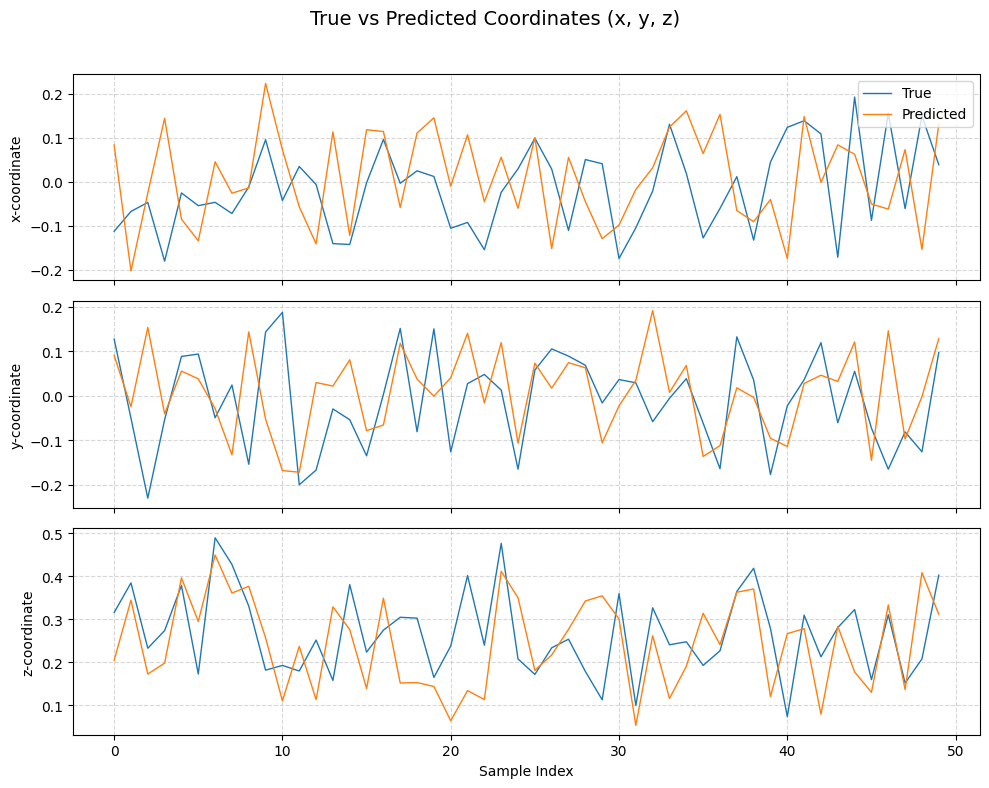

In [34]:
import matplotlib.pyplot as plt
#n_samples = y_true.shape[0]
n_samples = 50
t = np.arange(n_samples)
axes = ['x', 'y', 'z']

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i, ax in enumerate(axs):
    ax.plot(t, y_true[0:n_samples, i], label='True', linewidth=1)
    ax.plot(t, y_pred[0:n_samples, i], label='Predicted', linewidth=1)
    ax.set_ylabel(f'{axes[i]}-coordinate')
    ax.grid(True, linestyle='--', alpha=0.5)
    if i == 0:
        ax.legend(loc='upper right')
    
axs[-1].set_xlabel('Sample Index')
fig.suptitle('True vs Predicted Coordinates (x, y, z)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()